## **Can <font color='darkred'>Heart Disease</font> be predicted?**

**Analysis By:**

Lisa Desjarlais, Shreyas Goyal, and Emma Szeto _(Group 155)._

<center><img src="https://gifs.eco.br/wp-content/uploads/2022/08/gifs-do-sistema-cardiovascular-0.gif" alt="Pictorial representation of a Human Heart" width="40%"> <img src="https://lh5.googleusercontent.com/hxLpYW3mP53JJSnWvUL9bB8zWvezzLWVHklVYPm2owl3xyik3PtPibwK5lXMy98fKICJZK7Ee8EP7ZvIUTVCey4ZW0_SftMKeMeooft9MoRiYOTdO2S2duo6QgiArcqZ9Y8qfe-E" alt="Heart Disease in USA" width="50%"/>

**Introduction:**
    
According to medical professionals at Johns Hopkins and Mount Sinai Health, there are five classifications of heart disease: Class 0 indicates no presence of heart disease, while classes 1 to 4 describe mild, moderate, severe and very severe heart disease, in that order <a href="(https://www.hopkinsmedicine.org/news/media/releases/updated_classification_system_captures_many_more_people_at_risk_for_heart_attack">(Johns Hopkins Medicine 2017)</a>. The goal of our project is to answer the predictive question: Can we use the health attributes available to us to predict whether a future patient (with an unknown diagnosis) has heart disease? For our project we will be analysing both the <a href="https://archive.ics.uci.edu/ml/datasets/Heart+Disease">Cleveland and Hungarian Heart Disease Data Sets.</a>  The Cleveland data set was compiled using the medical information of 303 patients, while the Hungary data set used 294 patients. Each row in the data sets represents a patient with some classification of heart disease and 13 other health attributes.

**Preprocessing the Data**

We begin our analysis by loading in all necessary libraries and our two data sets. We are using the tidyverse library to load, wrangle and plot our data. We set the seed as 14 such that our work is reproducible. We then proceed to wrangle, clean, add in our binary classification column, as was done in the proposal. Then, we combine our two data sets into one heart data set, which now has the medical information of 597 patients. 

In [1]:
# Loading in all necessary libraries.
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

# Setting the seed.
set.seed(14)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Loading in Cleveland data set
URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland_data <- read_csv(URL, col_names=FALSE, show_col_types = FALSE)

# Since column names aren't pre-specified, we rename them using colnames, according to the UCI repository.
colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")

cleveland_data <- cleveland_data |>
    mutate(ca = as.numeric(ca), thal = as.numeric(thal)) |>
    filter(ca != "NA", thal != "NA")

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


In [3]:
# Adding column indicating yes or no for presence of heart disease
cl_have_disease <- cleveland_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))
cl_no_disease <- cleveland_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))
cl_data_alt <- rbind(cl_have_disease, cl_no_disease)

In [4]:
# Loading in Hungarian data set
URL2 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"

hungarian_data <- read_delim(URL2, col_names = FALSE, delim = " ", show_col_types = FALSE)

colnames(hungarian_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")


# Combine levels 1,2,3,4 into hd column. Levels 1-4 as "yes", level 0 as "no."
hung_have_disease <- hungarian_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))

hung_no_disease <- hungarian_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))

hung_data_alt <- rbind(hung_have_disease, hung_no_disease)

In [5]:
heart_data <- rbind(hung_data_alt, cl_data_alt) |>
    select(-num)
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,yes
48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,yes
37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,yes
58,1,2,136,164,0,1,99,1,2.0,2,-9,-9,yes
49,1,4,140,234,0,0,140,1,1.0,2,-9,-9,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,2,122,192,0,0,174,0,0.0,1,0,3,no
56,1,2,130,221,0,2,163,0,0.0,1,0,7,no
56,1,2,120,240,0,0,169,0,0.0,3,0,3,no


Table 1. _The recorded medical data of all patients, alongside whether or not they have heart disease._

We then make note of the number of observations in our two classes. This helps us gauge how well our classifier is doing, since we can compare it to the majority classifier. If our classifier can improve its accuracy over 59% (our majority percentage), then our method is gaining valuable information from our predictors <a href="https://datasciencebook.ca/classification2.html#critically-analyze-performance">(Timbers et al., 2022)</a>.

In [6]:
# Percentages of hd (yes, no) 
num_obs_h <- nrow(heart_data)
heart_proportions <- heart_data |>
    group_by(hd) |>
    summarize(
        count = n(),
        percentage = n() / num_obs_h * 100
        )
heart_proportions

hd,count,percentage
<fct>,<int>,<dbl>
yes,243,41.11675
no,348,58.88325


Table 2. _The amount of patients with and without Heart Disease._

**Analysis**

We now begin our K-nn classification by splitting our heart data set into a training and testing set. 75% of our data will be allocated to the training set and 25% for the testing set.

In [7]:
# Creating Training and Testing Data Sets
heart_split <- initial_split(heart_data, prop = 0.75, strata = hd)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

**Finding the Best Predictors using Forward Selection**

In order to construct our classifier, we first need to select suitable predictors that can help us classify a new observation . Since we have $13$ variables to work with, we chose the method of forward selection to select the best predictors. According to the textbook, best subset selection is a method that trains all combinations of predictors and chooses the best accuracy. However, the method can become very slow once the number of predictors reaches 10 <a href="https://datasciencebook.ca/classification2.html#predictor-variable-selection">(Timbers et al., 2022)</a>. With $m = 13$ variables, we would have to train $2^m-1=8191$ models. Therefore, we chose to implement the method of forward selection, which chooses a list of candidate models and is more efficient to run (since it only trains $1/2m(m+1)=91$ models). The only tradeoff is perhaps a reduction in possible accuracy since not all possible models are trained  <a href="https://datasciencebook.ca/classification2.html#predictor-variable-selection">(Timbers et al., 2022)</a>. We felt this method fit the requirements of our project. The code for the forward selection method is from the textbook, section 6.8.3 <a href="https://datasciencebook.ca/classification2.html#predictor-variable-selection">(Timbers et al., 2022)</a>.

In [8]:
# Implementing Forward Selection Code to find best predictors
names <- colnames(heart_training |> select(-hd))

# Create a tibble to store accuracies
preds_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Create a model spec
knn_FS_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a 5-fold cross-validation object
heart_vfold_preds <- vfold_cv(heart_training, v = 5, strata = hd)

# Stores selected predictors
selected <- c()
# For every size from 1 to 13 predictors
for (i in 1:13) {
    # Stores preds not yet added
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # For each combo of preds we are creating a model string
        # and tuning the resultant classifier while collecting the accuracy
        # of the best k
        preds_new <- c(selected, names[[j]])
        model_string <- paste("hd", "~", paste(preds_new, collapse="+"))
        heart_FS_recipe <- recipe(as.formula(model_string),
                                data = heart_training) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors())
        acc <- workflow() |>
            add_recipe(heart_FS_recipe) |>
            add_model(knn_FS_spec) |>
            tune_grid(resamples = heart_vfold_preds, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        # Adding the result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    preds_accuracies <- preds_accuracies |>
        add_row(size = i,
                model_string = models[[jstar]],
                accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
preds_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,hd ~ oldpeak,0.7043508
2,hd ~ oldpeak+cp,0.7813449
3,hd ~ oldpeak+cp+thal,0.8130360
4,hd ~ oldpeak+cp+thal+fbs,0.8130110
5,hd ~ oldpeak+cp+thal+fbs+slope,0.8062944
⋮,⋮,⋮
9,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca,0.8083895
10,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach,0.8039451
11,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach+age,0.8151061


Table 3. _The estimated accuracy of classifier using different combinations of predictors._

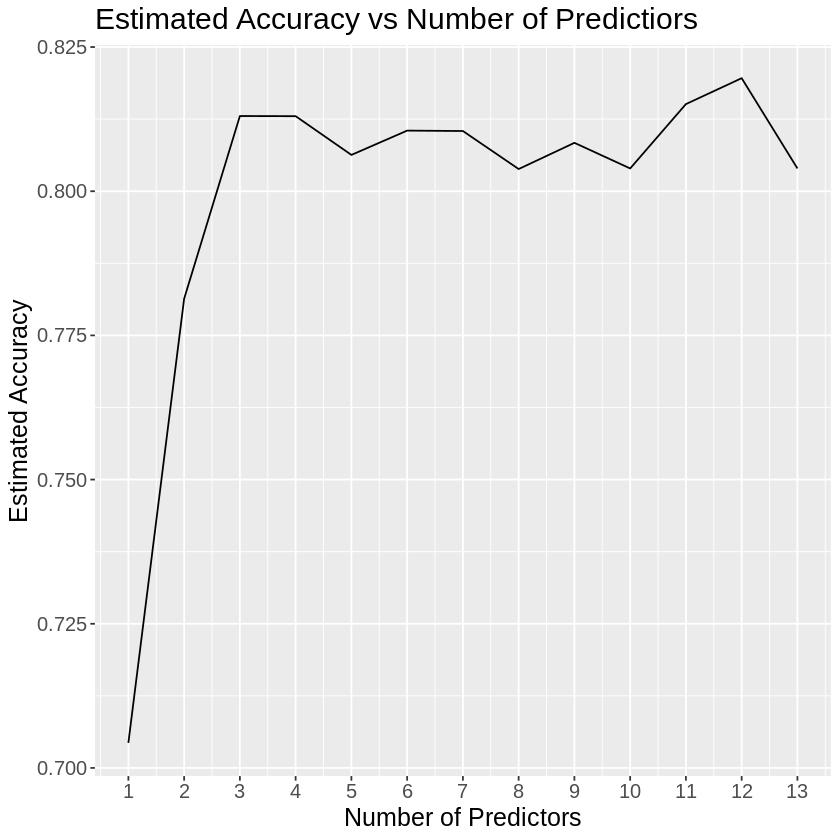

In [17]:
best_preds_plot <- ggplot(preds_accuracies, aes(x = size, y = accuracy)) +
    geom_line() +
    xlab("Number of Predictors") +
    ylab("Estimated Accuracy") +
    scale_x_continuous(breaks = 1:13) +
    ggtitle("Estimated Accuracy vs Number of Predictiors") +
    theme(text = element_text(size = 15))

best_preds_plot

Figure 1. _Graph of Estimated Accuracy vs. Number of Predictors._

In [10]:
best_preds <- preds_accuracies |> slice(3,4,12)
best_preds

size,model_string,accuracy
<int>,<chr>,<dbl>
3,hd ~ oldpeak+cp+thal,0.8130360
4,hd ~ oldpeak+cp+thal+fbs,0.8130110
12,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach+age+chol,0.8196011


Table 4. _The best 3 predicted accuracies, i.e. for 3, 4 and 12 predictors._

The best accuracy comes from using 12 predictors. However this may cause an overfitting of data, given that it involves a lot of predictors and it comes after some oscillation of accuracy in the data. <a href="https://pubs.acs.org/doi/10.1021/ci0342472">Hawkins (2004)</a> warns that overfitting is likely to occur when a more complex model is chosen over a simpler model with similar accuracy. According to  <a href="https://www.sciencedirect.com/science/article/pii/S0924271617303088">A.D. Rocha et al. (2017)</a>, overfitting may produce a high accuracy on the training data, but a lower accuracy on the test data. They also describe how a predictor may be irrelevant in predicting the class variable but may correlate well with another variable relevant to the class variable, resulting in a false accuracy when both variables are used. So choosing 12 predictors might not be the best option. The next best accuracy comes from using just 3 predictors, which is a lot simpler. Thus, the predictors we will choose to train our classifier are "oldpeak", "cp", and "thal". These represent ST depression induced by exercise relative to rest, chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic) and presence of heart defect (3 = normal, 6 = fixed defect, 7 = reversible defect) respectively.

**Tuning the Classifier**

Now, we want to tune the classifier in order to identify the best value of neighbours (k), in order to get the best accuracy for our classifier. We do this by tuning our classifier, which means testing different values of k, and then comparing the results at the end in order to choose that value of k for which our classifier's accuracy is the highest.

While tuning the classifier, we can create multiple classifiers based on multiple splits of the training data itself, evaluate them and then choose a value for the neighbours we want based on all the different results. This is known as V-Fold Cross Validation. We do this in order to reduce the chances of our classifier being arbitrarily good or bad, based on whether our data was lucky enough to end up in the validation set. Here, we perform a 10-fold Cross Validation, thereby using 10 different splits of our training data, in order to determine the best value of k.

Now, we first create a recipe that our classifier will follow, using the predictors that best predict heart disease, as found above. We step and scale all our predictors in order to make sure that our predictors have an equal influence on our classifier. Now, we can tune our classifier by using the nearest_neighbor() function, by setting the engine to "kknn" and mode to "classification" since we're performing a k-nn Classification. Now, we make a tibble of numbers from 1 to 50, which is a reasonable amount of neighbours to consider when we are looking at a population of 597 patients. Then, we combine everything into a workflow and produce the results of accuracies, for all the different possible values of k.

In [22]:
# Creating a 10-fold cross-validation object
set.seed(1975)
heart_vfold <- vfold_cv(heart_training, v = 10, strata = hd)

# Preparing the recipe according to the best predictors as found above
heart_recipe <- recipe(hd ~ oldpeak + cp + thal, data = heart_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

# k-nn Classification spec
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")

# Setting possible values of best k to be in between 1 and 50
gridvals <- tibble(neighbors = seq(1, 50))

# Combining everything into a workflow and collecting the metrics to identify the best value of k
knn_results <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples = heart_vfold, grid = gridvals) |>
                  collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7224967,10,0.01973460,Preprocessor1_Model01
1,roc_auc,binary,0.6842105,10,0.02162801,Preprocessor1_Model01
2,accuracy,binary,0.7270905,10,0.01656086,Preprocessor1_Model02
2,roc_auc,binary,0.7258978,10,0.02353036,Preprocessor1_Model02
3,accuracy,binary,0.7518401,10,0.01947026,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,roc_auc,binary,0.8525753,10,0.01458185,Preprocessor1_Model48
49,accuracy,binary,0.7858256,10,0.02014432,Preprocessor1_Model49
49,roc_auc,binary,0.8486580,10,0.01548871,Preprocessor1_Model49


Table 5. _Mean metrics and standard errors for different values of k._

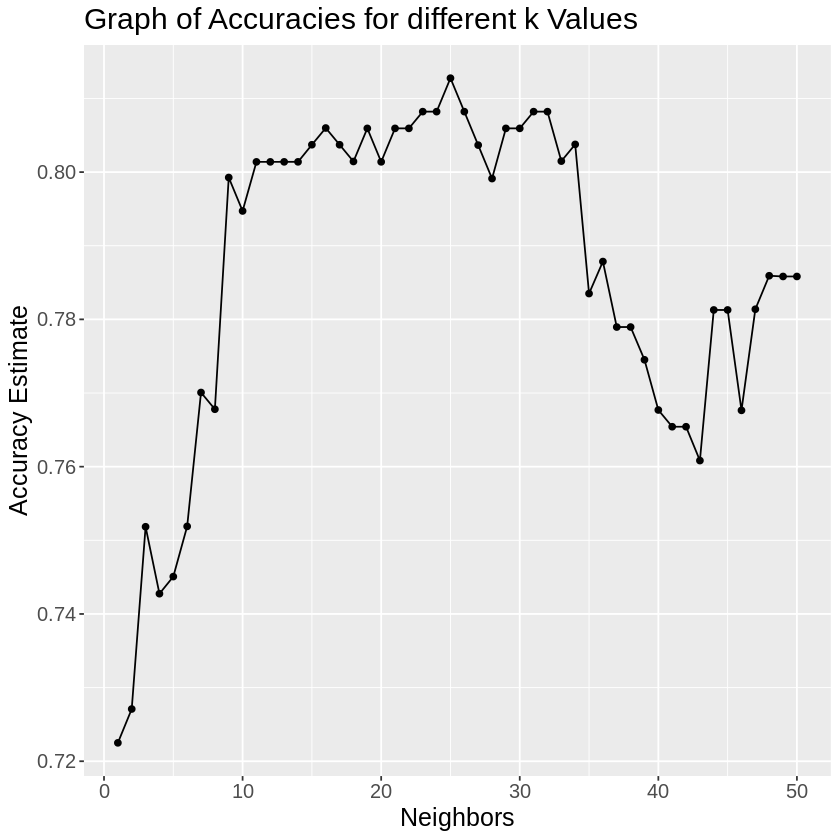

In [21]:
accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Creating a cross-validation plot to visualise accuracies for the different values of K
cross_val_plot <- accuracies |> 
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    ggtitle("Graph of Accuracies for different k Values") +
                    theme(text = element_text(size = 15))

cross_val_plot

Figure 2. _Graph of Accuracy Estimate vs. Neighbors._

Upon graphing the accuracies of our classifier for different values of k, we can see that the best value of k is somewhere between 20 and 30. Now, we can sort the accuracy results in descending order of their mean accuracy, and then pick the first entry of the tibble, which is our best k value.

In [12]:
# Choosing the best value of K
conclusions <- knn_results |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean, std_err) |>
                arrange(mean) |>
                tail(1)

conclusions

neighbors,mean,std_err
<int>,<dbl>,<dbl>
25,0.8127536,0.0166563


Table 6. _Best value of k, accuracy and standard error._

From the above conclusions, we can see that the best value for **k** to be used is **25**.

Now that we have identified the best value for k, we can make a new model specification for the best value of k and retrain the classifier. We will use the k-nearest neighbours to create a model specification with k = 25 and combine the model specification into a workflow that includes the recipe we previously made. Following, we will use the fit function to build the classifier. We will do so using the training data as we want to keep the testing data for the following steps. 

In [13]:
# Retraining the classifer 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_training)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(25,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1873589
Best kernel: rectangular
Best k: 25

After retraining the classifier, we can now test it by using it to predict labels on our test set. We will use the predict function on our testing set and the bind_cols function to merge the column of our predictions to the original data set. Therefore, we will be able to make a direct comparison of the predicted labels to the actual labels, with ".pred_class" representing our predictions and "hd" representing the true diagnosis.

In [14]:
# Predicting the labels in the test set
heart_test_predictions <- predict(knn_fit, heart_testing) |>
    bind_cols(heart_testing)
heart_test_predictions 

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
yes,37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,yes
yes,65,1,4,140,306,1,0,87,1,1.5,2,-9,-9,yes
no,54,0,3,130,294,0,1,100,1,0.0,2,-9,-9,yes
yes,41,1,4,110,289,0,0,170,0,0.0,-9,-9,6,yes
yes,47,0,4,120,205,0,0,98,1,2.0,2,-9,6,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
no,51,0,3,120,295,0,2,157,0,0.6,1,0,3,no
no,76,0,3,140,197,0,1,116,0,1.1,2,0,3,no
no,44,0,3,118,242,0,0,149,0,0.3,2,1,3,no


Table 7. _Classification of Heart Disease on the Test Set by classifier._

After predicting the labels on the testing set, we can follow our analysis by assessing our classifier's accuracy. In order to determine the quality of our model that we trained, we can use the metrics functions from tidymodels. We specify the column containing the true results in the truth argument and we use the estimate argument to denote which column contains our predictions. Further, we use the filter function to view the accuracy rows only. This step will help us analyse the performance of our classifier and it will give us an estimated accuracy.

In [15]:
# Computing the accuracy
heart_accuracies <- heart_test_predictions |>
    metrics(truth = hd, estimate = .pred_class) |>
    filter(.metric =="accuracy")
heart_accuracies

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8243243


Table 8. _Final Accuracy for the Classifier._

The final step in our classification is to look at the confusion matrix for the classifier. This is a table that will compare the predicted labels against the correct labels. We can do so by using the conf_mat function and again, specifying which columns contain our predictions and also which column contains the true values. By conducting this final step, we can get a numerical representation of how many labels our classifier was able to successfully predict. 

In [16]:
# Looking at the confusion matrix
confusion <- heart_test_predictions |>
             conf_mat(truth = hd, estimate = .pred_class)
confusion 

          Truth
Prediction yes no
       yes  44  9
       no   17 78

Table 9. _Confusion Matrix for the classifier, comparing true positives, false positives, true negatives and false negatives._

After looking at the confusion matrix for the classifier, we can see that 44 observations were correctly predicted as "yes" and 78 observations were correctly predicted as "no". However, our classifier did make some mistakes as it misclassified 9 observations as "yes" and 17 observations as "no".

**Discussion**

Heart disease is the leading cause of death world wide and finding better ways to predict heart disease early is crucial in preventing deaths <a href="https://doi.org/10.1016/j.tele.2018.11.007">(Amin et al., 2019)</a>. Heart disease is known as a “silent killer,” as 45% of all heart attacks do not display the typical symptoms of a heart attack <a href="https://www.health.harvard.edu/heart-health/the-danger-of-silent-heart-attacks">(“Danger of ‘silent’,” 2020)</a>. <a href="https://doi.org/10.7326/0003-4819-157-7-201210020-00514">MD Virginia A. Moyer (2012)</a> warns, the first symptom of heart disease for some people may be a sudden fatal heart attack. Thus, it is imperative to find a way to predict heart disease based on other health factors. Our classifier obtained an 82.43% accuracy on our test data set. This is a significant improvement upon our majority classifier, which would return a 59% accuracy. Therefore, our method is gaining valuable information from our predictors. Thus, by knowing "oldpeak," "cp," and "thal" can be used to predict heart disease with a 82.43% accuracy, a physician can take care to observe those factors in their patients leading to earlier detection. However, in practice an 82.43% accuracy should be improved upon because of the need for a reliable diagnosis of heart disease, due to the seriousness of the disease, sometimes lack of symptoms, and need for early intervention. Our classifier predicted “no” when in truth it was “yes” (a false negative diagnosis) almost twice the amount of times it predicted a false positive diagnosis of heart disease. Thus, there is room for improvement within our method since our classifier is not accurate 17.57% of the time and it may have fatal consequences. 

Using the Cleveland data set, <a href="https://doi.org/10.1016/j.tele.2018.11.007">Amin et al. (2019)</a> ran seven classification techniques and determined the best accuracies. Using best subset selection and a binary classification, they found the highest accuracy when using k-nn classification to be 82.49% when using the predictors: sex, cp, fbs, restecg, oldpeak, ca, thal. This score is very similar to ours and using best subset selection appears to have only improved the accuracy score slightly. However, they found the best accuracy at 86.87% by using the Support Vector Machine technique and the predictors: age, sex, cp, chol, fbs, exang, oldpeak, slope, ca. Therefore to improve our accuracy score for real world applications we can consider using SVM analysis and choosing our predictors with the best subset selection method, which we’ve mentioned tries all possible combinations of predictors resulting in a higher accuracy than forward selection.

In this project, we explored the factors that impact heart disease. We ran many tests to find the factors that will have the greatest influence in predicting whether or not a new patient will have heart disease. After concluding that rest (oldpeak), chest pain type (cp) and presence of heart defect (thal) were the best predictors, we noted a 82.43% accuracy on our test set. These conclusions are very encouraging as classifiers similar to the one we created can be used to predict not only heart disease but many other medical conditions and diseases. Even though our classifier had a 82.43% accuracy, the results can be used to identify the leading risk factors for heart disease. With that, if a medical professional notices a patient with a certain chest pain type, they may be more likely to investigate possible heart disease.

Our findings from this project can lead us to future questions such as how we can use these types of classifiers to help predict other medical conditions. In the future, it is possible that classification can potentially help prevent the development of diseases as it may speed up the diagnostic process.

In conclusion, our classifier has answered the question that we had set out to answer. Heart Disease can indeed be predicted.

**References**

Amin, M. S., Chiam, Y. K., & Varathan, K. D. (2019). Identification of significant features and data mining techniques in predicting heart disease. Telematics and Informatics, 36, 82-93. https://doi.org/10.1016/j.tele.2018.11.007

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Hawkins, D. M. (2004). The problem of overfitting. Journal of Chemical Information and Computer Sciences, 44(1), 1-12. https://doi.org/10.1021/ci0342472

Heart Disease in USA gif: https://lh5.googleusercontent.com/hxLpYW3mP53JJSnWvUL9bB8zWvezzLWVHklVYPm2owl3xyik3PtPibwK5lXMy98fKICJZK7Ee8EP7ZvIUTVCey4ZW0_SftMKeMeooft9MoRiYOTdO2S2duo6QgiArcqZ9Y8qfe-E

Heart gif: https://gifs.eco.br/wp-content/uploads/2022/08/gifs-do-sistema-cardiovascular-0.gif

Johns Hopkins Medicine (2017, January 11). _Updated Classification System Captures Many More People at Risk for Heart Attack_. https://www.hopkinsmedicine.org/news/media/releases/updated_classification_system_captures_many_more_people_at_risk_for_heart_attack

MOYER, V. A., & U.S. Preventive Services Task Force. (2012). Screening for coronary heart disease with electrocardiography: U.S. preventive services task force recommendation statement. Annals of Internal Medicine, 157(7), 512-518. https://doi.org/10.7326/0003-4819-157-7-201210020-00514

Rocha, A. D., Groen, T. A., Skidmore, A. K., Darvishzadeh, R., & Willemen, L. (2017). The naïve overfitting index selection (NOIS): A new method to optimize model complexity for hyperspectral data. ISPRS Journal of Photogrammetry and Remote Sensing, 133, 61-74. https://doi.org/10.1016/j.isprsjprs.2017.09.012

The danger of “silent” heart attacks. (2020, November 3). Harvard Health Publishing. https://www.health.harvard.edu/heart-health/the-danger-of-silent-heart-attacks

Timbers, T., Campbell, T., & Lee, M. (2022). Data science: A first introduction. CRC Press LLC.